# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import h5py
import re
from typing import Optional

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight
from src.models import nmf_missing
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3981, 822)

# Read metadata

In [5]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Dcum2,QPS Crate,QPS Board,#Segment,phys_pos,Name,R_1,R_2,RRR_1,RRR_2
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,268.9040,B8R1,0,79,1,A8R1,1.80,1.85,95.650088,94.103943
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,284.5640,B9R1,0,77,2,B8R1,1.67,1.85,100.314516,94.103943
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,307.9690,B8R1,1,80,3,A9R1,1.75,1.85,97.936878,94.103943
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,323.6290,B11R1,2,76,4,B9R1,1.67,1.77,100.314516,97.371760
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,348.4340,B10R1,0,81,5,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,26294.7892,B10L1,1,75,150,A10L1,2.53,3.13,78.314002,70.353447
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,26319.5942,B9L1,1,80,151,B9L1,3.25,3.70,68.099268,54.735949
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,26335.2542,B10L1,2,76,152,A9L1,3.09,1.75,70.748254,99.628927
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,26358.6592,B9L1,0,79,153,B8L1,2.43,2.43,79.915648,79.899869


# Read position map

In [6]:
pos_map_path = Path("../data/circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)

In [7]:
df_pos_map_subset = df_pos_map[(df_pos_map["Circuit"] == 'RB.A12') & (df_pos_map["El. Quench Position"] == 0)].reset_index(drop=True)
value_columns = df_pos_map_subset.filter(regex= ". ").columns
df_pos_map_subset[value_columns] = (df_pos_map_subset[value_columns] +1)
df_pos_map_subset.T

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,...,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12
Magnet,MB.A8L2,MB.A9L2,MB.A10L2,MB.A11L2,MB.A12L2,MB.C12L2,MB.B13L2,MB.A14L2,MB.C14L2,MB.B15L2,...,MB.C15L2,MB.A15L2,MB.B14L2,MB.C13L2,MB.A13L2,MB.B12L2,MB.B11L2,MB.B10L2,MB.B9L2,MB.B8L2
El. Position,1,2,3,4,5,6,7,8,9,10,...,145,146,147,148,149,150,151,152,153,154
Phys. Position,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Dist. to PC,1,3,5,7,9,11,13,15,17,19,...,20,18,16,14,12,10,8,6,4,2
Phys. Position ODD,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Position EVEN,2,4,6,8,10,12,14,16,18,20,...,19,17,15,13,11,9,7,5,3,1
El. Quench Position,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Phys. Quench Position,154,154,154,154,154,154,154,154,154,154,...,154,154,154,154,154,154,154,154,154,154
Phys. Dist. to Quench,155,153,151,149,147,145,143,141,139,137,...,136,138,140,142,144,146,148,150,152,154


In [8]:
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing

# Load Data

In [9]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

fpa_identifiers = mp3_fpa_df[#(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 > sec_after_prim_quench) &
                             (mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)
                             ].fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x) for x in dataset_2EE_fft.data])
data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

# Non-negative components - NMF

In [10]:
all_fpa_identifiers = mp3_fpa_df[(mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)].fpa_identifier.unique()
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)]

use_fpa_identifier = False
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A23_1620923593800000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 1 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

(1,
 array('RB_RB.A78_1615271973700000000', dtype='<U29'),
 '2021-03-09 07:39:33.678000')

## 1st Energy Extraction Plateau

In [11]:
n_components = 10
W_1EE, H_1EE, n_iter = nmf_missing.non_negative_factorization(data_1EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1)

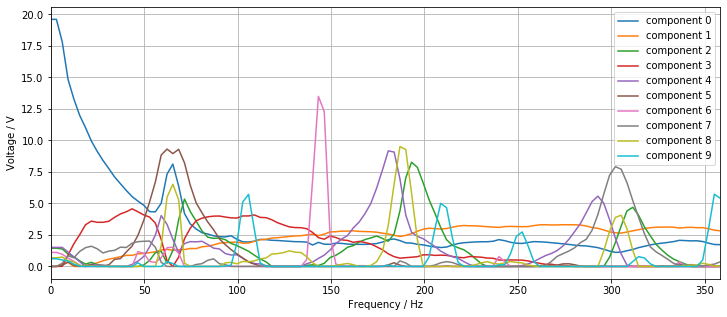

In [12]:
plot_nmf_components(H_1EE, dataset_1EE_fft)

In [13]:
merge_component_index = [0, 1, 3, [2,4,5,7,8], 6, 9]
H_1EE_merged = merge_array(H_1EE.T, merge_component_index, axis=-1, func=np.sum).T
component_weights_1EE = merge_array(W_1EE, merge_component_index, axis=-1, func=np.mean)

max_H = H_1EE_merged.max(axis=1, keepdims=True)
H_1EE_processed = H_1EE_merged / max_H
component_weights_1EE = (component_weights_1EE * np.expand_dims(max_H.T, axis=0))[0]

### Check components

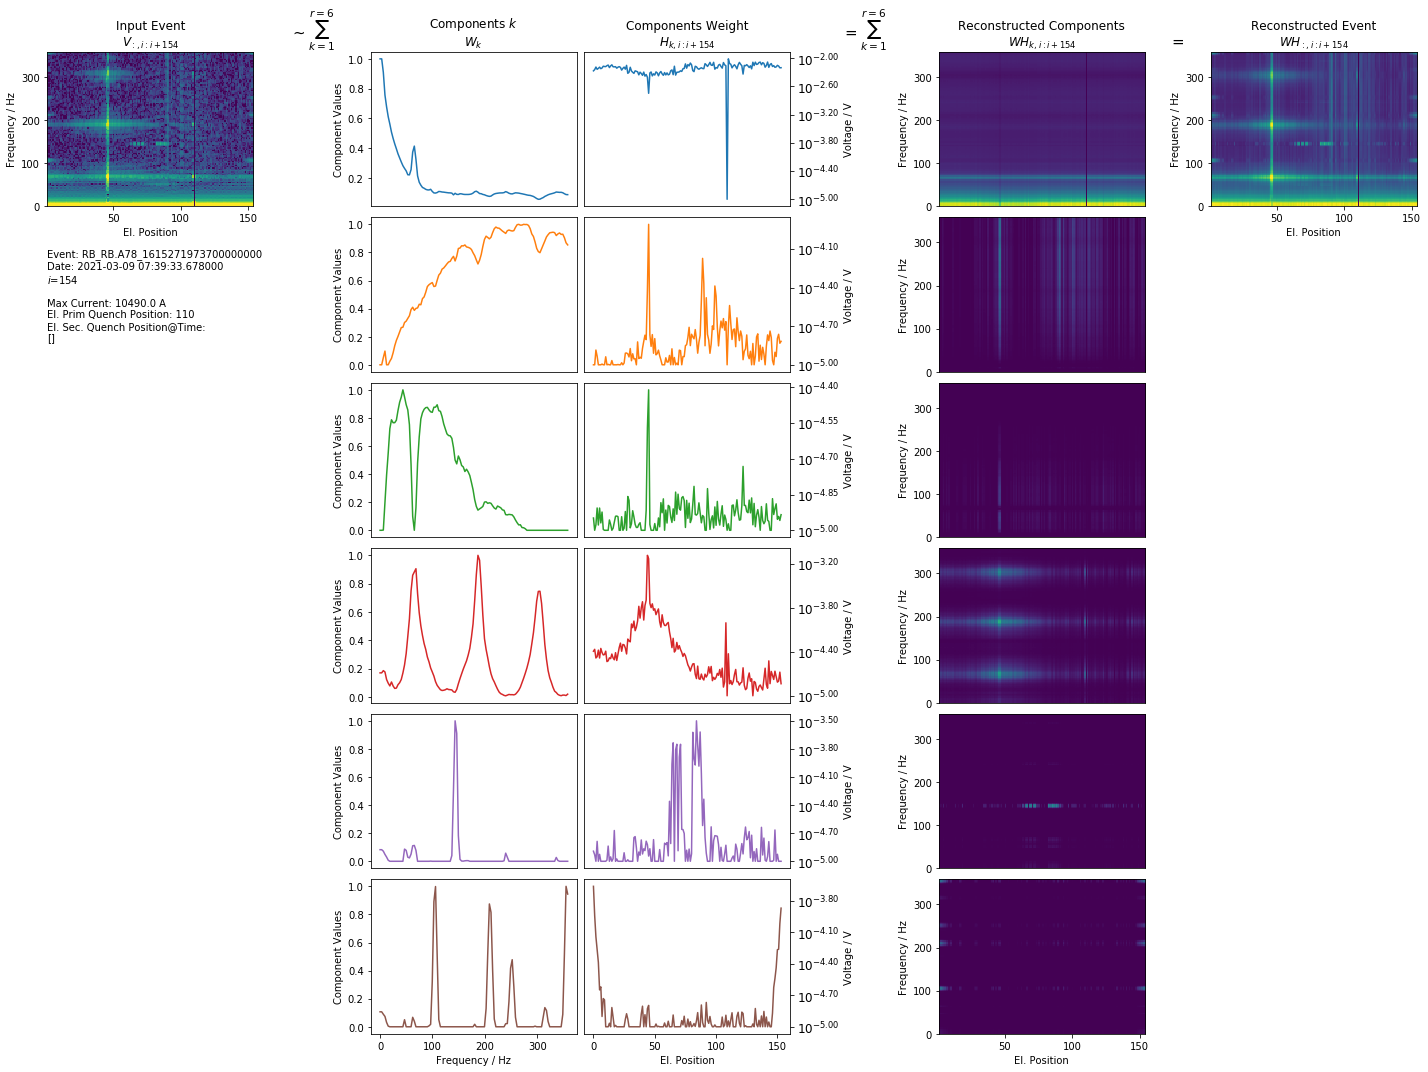

In [14]:
component_indexes_1EE = [0, 1, 2, 3, 4, 5]
plot_nmf_event_composition(data_1EE, component_weights_1EE, H_1EE_processed, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df)

### Distribution of Component weights

In [15]:
mp3_fpa_df_subset = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers)]
mp3_fpa_df_pos_subset = mp3_fpa_df_subset.rename(columns={'#Electric_circuit':"El. Quench Position", 'phys_position': "Phys. Quench Position"})
mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] = mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] - 1

el_filt_list = mp3_fpa_df_pos_subset[['Circuit', "El. Quench Position"]].to_dict(orient='records')
phys_filt_list = mp3_fpa_df_pos_subset[['Circuit', "Phys. Quench Position"]].to_dict(orient='records')

In [17]:
component_weights_1EE_reshaped = component_weights_1EE.copy().reshape(-1, 154, len(component_indexes_1EE))
sort_columns = ['El. Position', 'Phys. Position', 'Phys. Position ODD', 'Phys. Position EVEN', 'Phys. Dist. to PC', 'Phys. Dist. to Quench', 'El. Dist. to Quench Main', 'El. Dist. to Quench Mirror']

c_weights_dict = {}
current_sort = 'El. Position'
for target in sort_columns:
    print(target)
    max_index = int(df_pos_map[target].max())
    if "El." in target:
        filt_list = el_filt_list
    elif "Phys." in target:
        filt_list = phys_filt_list
        
    mask = np.empty((component_weights_1EE_reshaped.shape[0], max_index+1, component_weights_1EE_reshaped.shape[-1])) * np.nan
    for i, f in enumerate(filt_list):
        index = map_position_index(df_pos_map, origin=current_sort, to=target, filt=f)
        target_index = map_position_index(df_pos_map, origin=target, to=target, filt=f)
        mask[i][target_index] = component_weights_1EE_reshaped[i][index]

    if 'Quench' in target: 
        x_label = np.arange(-int((max_index+1)/2),  int((max_index+2)/2))
    else:
        x_label = np.arange(1, int(max_index+2))
            
    c_weights_dict[target] = {"values": mask,
                             "index": x_label}

El. Position
Phys. Position
Phys. Position ODD
Phys. Position EVEN
Phys. Dist. to PC
Phys. Dist. to Quench
El. Dist. to Quench Main
El. Dist. to Quench Mirror


In [18]:
# add snr for each method
for sort in c_weights_dict:
    y = np.nanmean(c_weights_dict[sort]["values"], axis=0)
    error = np.nanstd(c_weights_dict[sort]["values"], axis=0)
    c_weights_dict[sort]["snr"] = np.nanmean(calc_snr(y, error), axis=0)

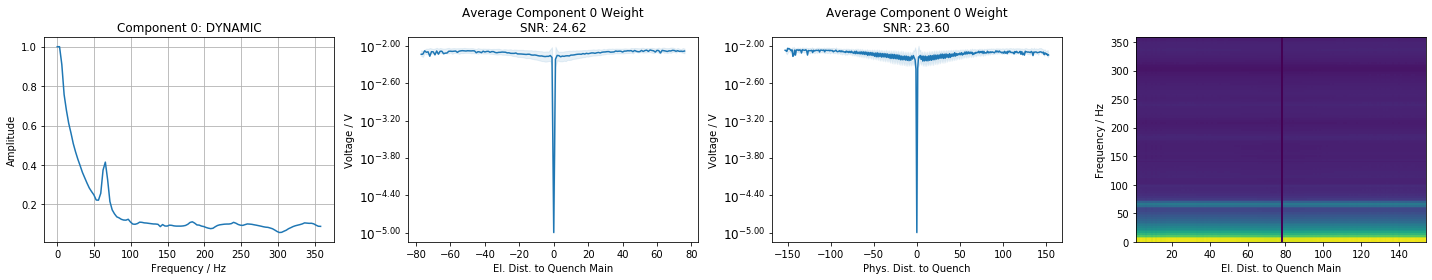

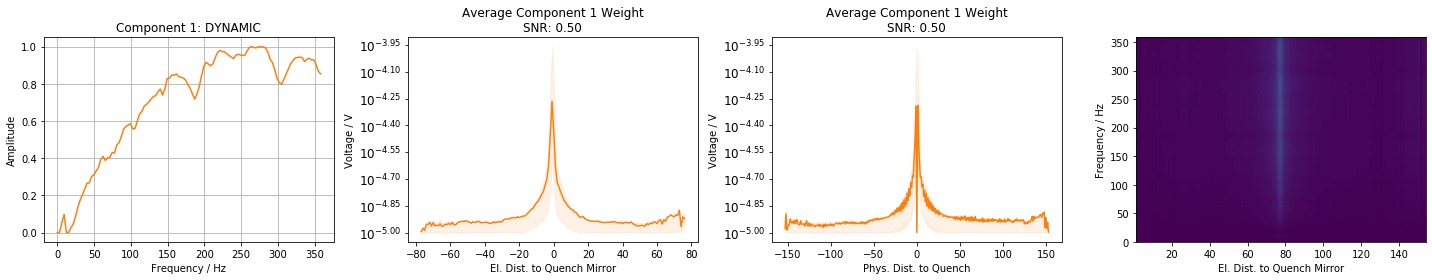

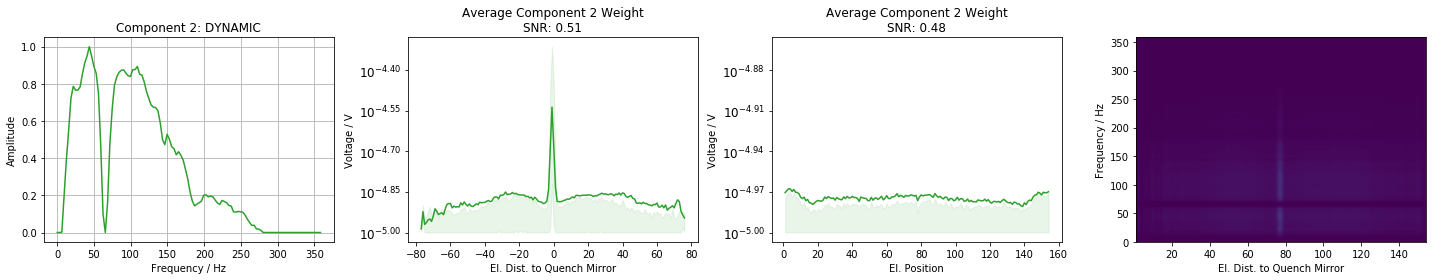

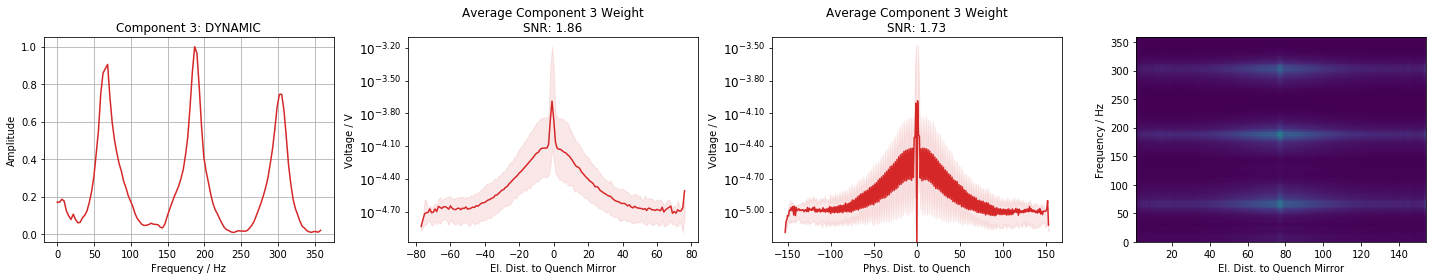

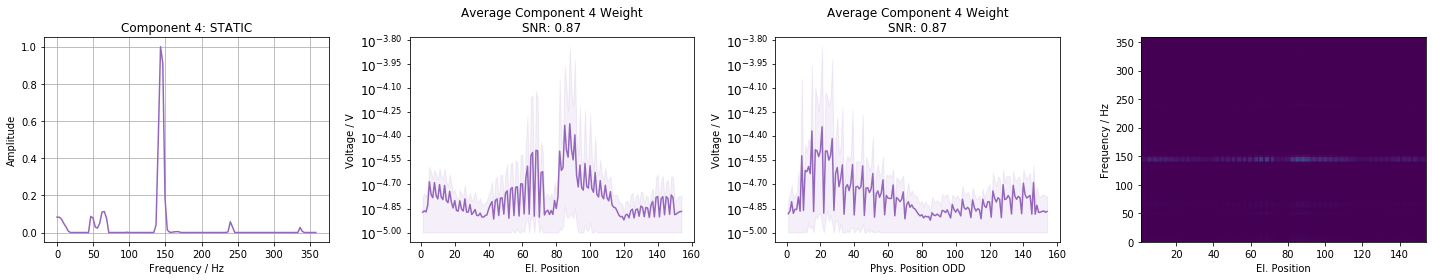

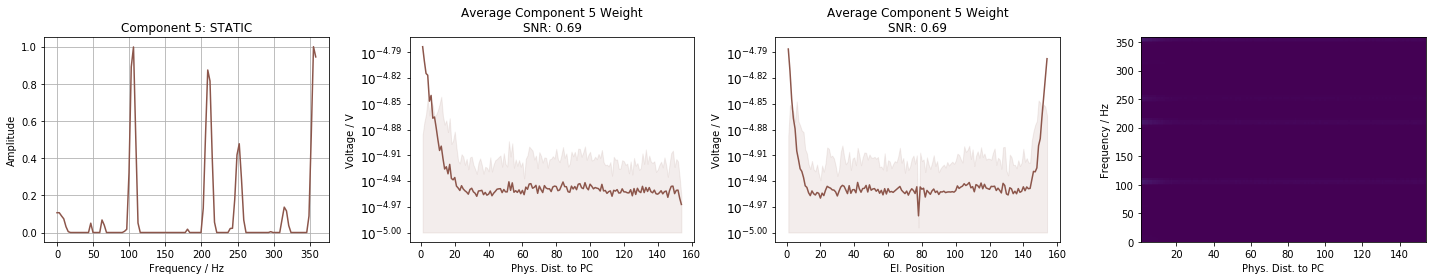

In [19]:
plot_n_highest_snr =  2#len(c_weights_dict)
n_components = c_weights_dict["El. Position"]["values"].shape[-1]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2

best_sort_index = []
for k in range(n_components): 
    
    snr_sorted_index = np.argsort([-c_weights_dict[sort]["snr"][k] for sort in c_weights_dict])[:plot_n_highest_snr]
    best_sort_index.append(snr_sorted_index[0])
    
    fig, ax = plt.subplots(1,plot_n_highest_snr+2, figsize =(5*(plot_n_highest_snr+2),4))
    ax[0].plot(dataset_1EE_fft.frequency, H_1EE_processed[k], c=default_colors[k % n_components])
    ax[0].set_title(f"Component {k}")
    ax[0].set_xlabel("Frequency / Hz")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid()
    
    if "Quench" in list(c_weights_dict)[snr_sorted_index[0]]:
        ax[0].set_title(f"Component {k}: DYNAMIC")
    else:
        ax[0].set_title(f"Component {k}: STATIC")
    
    for i, sort in enumerate(np.array(list(c_weights_dict))[snr_sorted_index]):
        plot_avg_component_weight(ax[i+1], c_weights_dict[sort], component_number=k, xlabel=sort)
        
        yticks = ax[i+1].get_yticks().tolist()
        
        ax[i+1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
        ax[i+1].set_ylabel("Voltage / V")
        ax[i+1].set_ylim(ax[1].get_ylim())

    
    best_sort = list(c_weights_dict)[snr_sorted_index[0]]
    V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, k:k+1] @  H_1EE_processed[k:k+1]
    plot_position_frequency_map(ax[-1], V_mean, dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1)
    ax[-1].set_xlabel(best_sort)
    ax[-1].set_ylabel("Frequency / Hz")
    
    plt.tight_layout()
    

 divide dependent on position in cryostat
rb_magnet_metadata['cryostat_group'] = rb_magnet_metadata['Cryostat2'].apply(lambda x: x.split('_')[1])
last_mpos_in_cryostat = rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values
cryostat_position = [rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].groupby("cryostat_group").nth(i).sort_values(by='phys_pos').phys_pos.values for i in range(3)]

### Simulate FP-map given components

In [20]:
n_quench_pos = 154
V_mean_1EE = np.zeros((n_quench_pos,) + dataset_1EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index):
        best_sort = list(c_weights_dict)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)
        V_mean_1EE[quench_pos] += V_mean

## 2nd Energy Extraction Plateau

In [21]:
n_components = 12
W_2EE, H_2EE, n_iter = nmf_missing.non_negative_factorization(data_2EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1, max_iter=200)

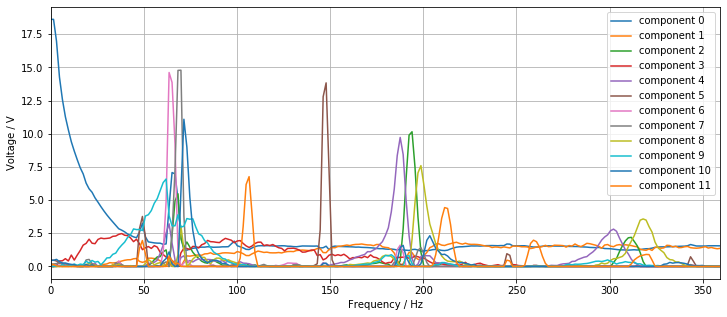

In [22]:
plot_nmf_components(H_2EE, dataset_2EE_fft)

In [23]:
merge_component_index = [0, [1,3], [2,4,8], [9, 7,10,6], 5, 11]
H_2EE_merged = merge_array(H_2EE.T, merge_component_index, axis=-1, func=np.sum).T
component_weights_2EE = merge_array(W_2EE, merge_component_index, axis=-1, func=np.mean)

max_H = H_2EE_merged.max(axis=1, keepdims=True)
H_2EE_processed = H_2EE_merged / max_H
component_weights_2EE = (component_weights_2EE * np.expand_dims(max_H.T, axis=0))[0]

### Check components

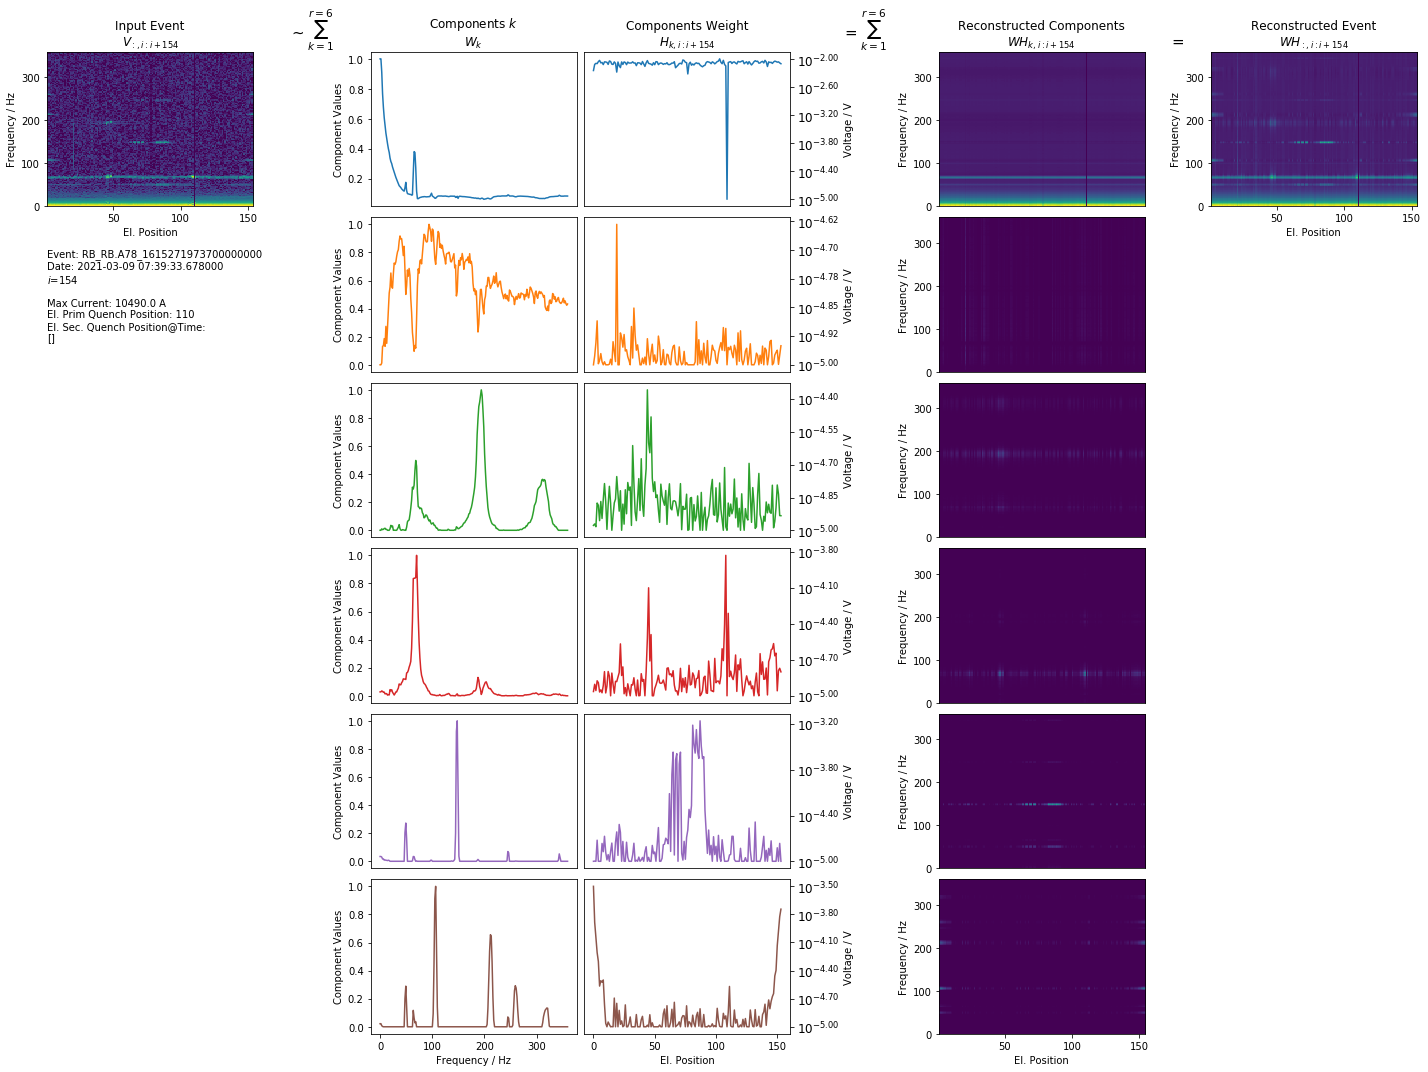

In [26]:
component_indexes_2EE = [0,1,2,3,4,5]
plot_nmf_event_composition(data_2EE, component_weights_2EE, H_2EE_processed, component_indexes_2EE, dataset_2EE_fft, fpa_identifier, mp3_fpa_df)

### Distribution of Component weights

In [28]:
component_weights_2EE_reshaped = component_weights_2EE.copy().reshape(-1, 154, len(merge_component_index))
sort_columns = ['El. Position', 'Phys. Position', 'Phys. Position ODD', 'Phys. Position EVEN', 'Phys. Dist. to PC', 'Phys. Dist. to Quench', 'El. Dist. to Quench Main', 'El. Dist. to Quench Mirror']

c_weights_dict_2EE = {}
current_sort = 'El. Position'
for target in sort_columns:
    print(target)
    max_index = int(df_pos_map[target].max())
    if "El." in target:
        filt_list = el_filt_list
    elif "Phys." in target:
        filt_list = phys_filt_list
        
    mask = np.empty((component_weights_2EE_reshaped.shape[0], max_index+1, component_weights_1EE.shape[-1])) * np.nan
    for i, f in enumerate(filt_list):
        index = map_position_index(df_pos_map, origin=current_sort, to=target, filt=f)
        target_index = map_position_index(df_pos_map, origin=target, to=target, filt=f)
        mask[i][target_index] = component_weights_2EE_reshaped[i][index]

    if 'Quench' in target: 
        x_label = np.arange(-int((max_index+1)/2),  int((max_index+2)/2))
    else:
        x_label = np.arange(1, int(max_index+2))
            
    c_weights_dict_2EE[target] = {"values": mask,
                             "index": x_label}

El. Position
Phys. Position
Phys. Position ODD
Phys. Position EVEN
Phys. Dist. to PC
Phys. Dist. to Quench
El. Dist. to Quench Main
El. Dist. to Quench Mirror


In [29]:
# add snr for each method
for sort in c_weights_dict_2EE:
    y = np.nanmean(c_weights_dict_2EE[sort]["values"], axis=0)
    error = np.nanstd(c_weights_dict_2EE[sort]["values"], axis=0)
    c_weights_dict_2EE[sort]["snr"] = np.nanmean(calc_snr(y, error), axis=0)

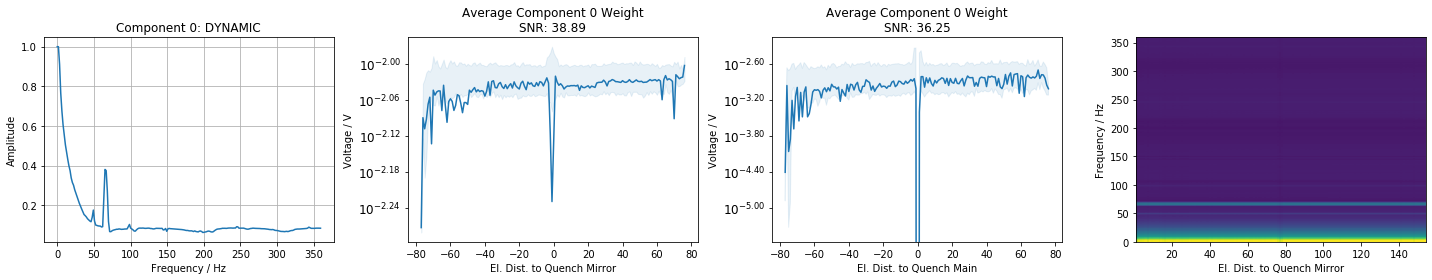

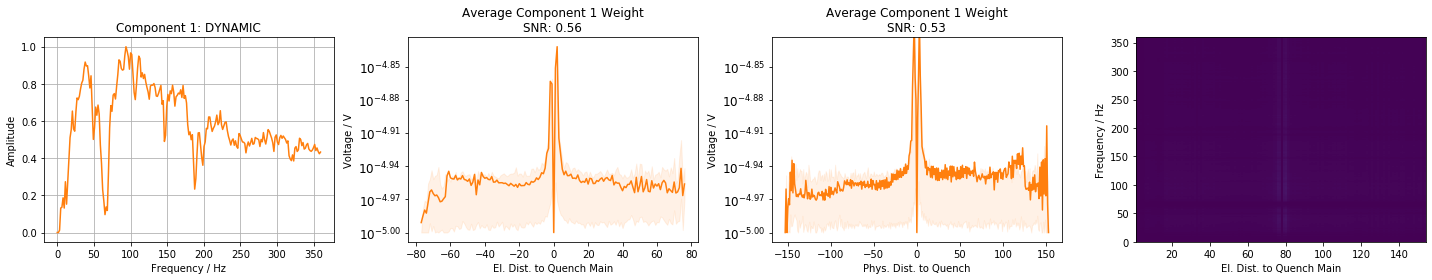

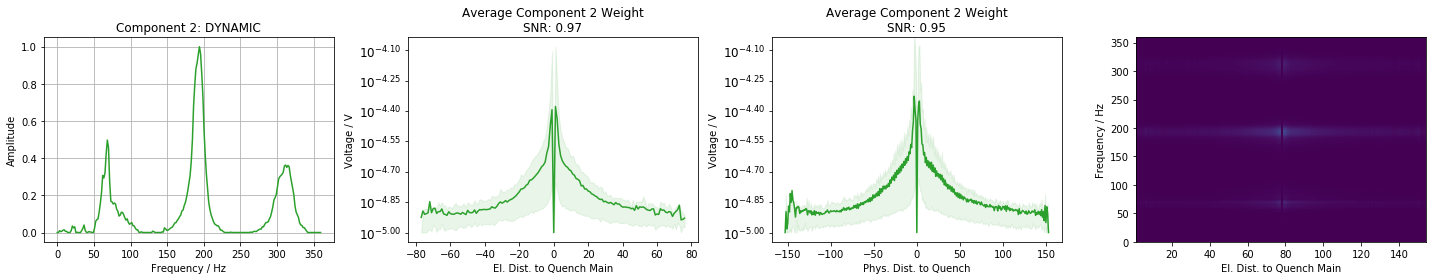

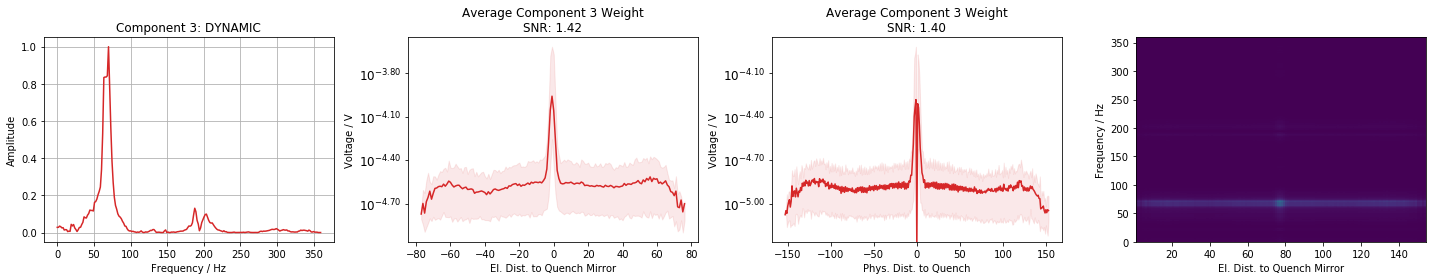

In [ ]:
plot_n_highest_snr =  2#len(c_weights_dict_2EE)
n_components = c_weights_dict_2EE["El. Position"]["values"].shape[-1]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2

best_sort_index_2EE = []
for k in range(n_components): 
    
    snr_sorted_index = np.argsort([-c_weights_dict_2EE[sort]["snr"][k] for sort in c_weights_dict_2EE])[:plot_n_highest_snr]
    best_sort_index_2EE.append(snr_sorted_index[0])
    
    fig, ax = plt.subplots(1,plot_n_highest_snr+2, figsize =(5*(plot_n_highest_snr+2),4))
    ax[0].plot(dataset_2EE_fft.frequency, H_2EE_processed[k], c=default_colors[k % n_components])
    ax[0].set_title(f"Component {k}")
    ax[0].set_xlabel("Frequency / Hz")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid()
    
    if "Quench" in list(c_weights_dict_2EE)[snr_sorted_index[0]]:
        ax[0].set_title(f"Component {k}: DYNAMIC")
    else:
        ax[0].set_title(f"Component {k}: STATIC")
    
    for i, sort in enumerate(np.array(list(c_weights_dict_2EE))[snr_sorted_index]):
        plot_avg_component_weight(ax[i+1], c_weights_dict_2EE[sort], component_number=k, xlabel=sort)
        
        yticks = ax[i+1].get_yticks().tolist()
        
        ax[i+1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
        ax[i+1].set_ylabel("Voltage / V")
        ax[i+1].set_ylim(ax[1].get_ylim())

    
    best_sort = list(c_weights_dict_2EE)[snr_sorted_index[0]]
    V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, k:k+1] @  H_2EE_processed[k:k+1]
    plot_position_frequency_map(ax[-1], V_mean, dataset_2EE_fft.frequency, norm=None, vmin=0, vmax=1)
    ax[-1].set_xlabel(best_sort)
    ax[-1].set_ylabel("Frequency / Hz")
    
    plt.tight_layout()

In [ ]:
n_quench_pos = 154
V_mean_2EE = np.zeros((n_quench_pos,) + dataset_2EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index_2EE):
        best_sort = list(c_weights_dict_2EE)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict_2EE)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict_2EE)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict_2EE)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)
        V_mean_2EE[quench_pos] += V_mean

# Simulate FP-map given components for both EE

In [ ]:
output_path = Path(f"../output/nmf_decomposition.py/simulation_all")
output_path.mkdir(parents=True, exist_ok=True)

im_paths = []   
circuit = 'RB.A12'
for quench_pos in range(n_quench_pos):
    phys_pos_index = map_position_index(df_pos_map, origin="El. Position", to='Phys. Position', filt={'Circuit': circuit, 'El. Quench Position': quench_pos})
    phys_quench_pos = map_position_index(df_pos_map, old_index=[quench_pos], origin="Phys. Position", to='El. Position', filt={'Circuit': 'RB.A12', 'El. Quench Position': quench_pos})[0]
    
    fig, ax = plt.subplots(2,3, figsize = (15,10), gridspec_kw={ 'width_ratios': [4, 4, 1]})
    
    plot_position_frequency_map(ax[0, 0], V_mean_1EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 0].set_title(f"U_Diode @ 1st EE, El. Quench Position: {quench_pos+1}")
    ax[0, 0].set_ylabel("Frequency / Hz")
    ax[0, 0].set_xlabel("El. Position")
    
    im = plot_position_frequency_map(ax[0, 1], V_mean_1EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[0, 1].set_ylabel("Frequency / Hz")
    ax[0, 1].set_xlabel("Phys. Position")
    
    plot_position_frequency_map(ax[1, 0], V_mean_2EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 0].set_title(f"U_Diode @ 2nd EE, El. Quench Position: {quench_pos}")
    ax[1, 0].set_ylabel("Frequency / Hz")
    ax[1, 0].set_xlabel("El. Position")
    
    plot_position_frequency_map(ax[1, 1], V_mean_2EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[1, 1].set_ylabel("Frequency / Hz")
    ax[1, 1].set_xlabel("Phys. Position")
    
    cbar = fig.colorbar(im, ax=ax[0, 2], fraction=1)
    ax[0, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)
    
    cbar = fig.colorbar(im, ax=ax[1, 2], fraction=1)
    ax[1, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)

    im_path = output_path / f"{quench_pos+1}.png"
    im_paths.append(im_path)
    plt.tight_layout()
    plt.savefig(im_path)
    plt.close(fig)

In [ ]:
from PIL import Image
imgs = (Image.open(f) for f in im_paths)
img = next(imgs)  # extract first image from iterator
img.save(fp=output_path / "summary.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)